<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Eye_crop_bilateral_periocular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#顔の画像から目を検出して切り抜くスクリプト
・Haarcascade_eyeを使用<br>
・目が検出できないものはskipする<br>
・横幅を1/4倍、縦幅を上下に1/4倍追加して画像を切り取る（目の全幅、眉毛が含まれるように）

・切り取った画像を500px*500pxにresizeする<br>
・フォルダ内の画像を一括変換して別フォルダに保存

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys


import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

#Google colabをマウント

In [2]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加して画像を切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


残り時間 : 11.98

In [4]:
#元画像
in_path = '/content/drive/MyDrive/Deep_learning/Face_Images/IMG_3110.JPG'
in_path = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset/799.JPG'
#保存先フォルダ
out_path = '/content/drive/My Drive/Deep_learning/eyelid_images/IMG_3110_eye.JPG'


#Haarcascadeを指定

In [5]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

In [6]:
#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)

#図を表示する
def show_image(img):
    #img = cv2.imread(out_path)
    dst = scale_to_width(img, 200)
    cv2_imshow(dst)

def show_image_pillow(img):
    src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
    plt.imshow(src)

def my_round(val, digit=0):
    p = 10 ** digit
    return int((val * p * 2 + 1) // 2 / p)

In [10]:
def crop_bilateral(in_path, size, showImage=True):
    img_resized_list,side_list = [],[]

    img = cv2.imread(in_path) 
    img2 = img.copy()

    if showImage:
        show_image(img)

    # 画像グレースケール化
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #300pix以上のもので目に見えるものを抽出
    eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
    print("")
    print('image path = ',in_path)

    # 眼検出判定
    if len(eye_list) >= 1:
        print('目が' + str(len(eye_list)) +'個検出されました')
        pass
    else:
        print("no eye detected")
        pass

    print(eye_list)

    #画像の切り抜きと保存（連番にする）
    if len(eye_list)>= 1: 
        for (ex, ey, ew, eh) in eye_list:
            print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
            
            try:
              cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

              #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
              top = max(0, ey-int(eh/4))
              bottom = min(grayscale_img.shape[0], int(ey + eh*5/4))
              left = max(0,int(ex-int(ew/4)))
              right = min(grayscale_img.shape[1], int(ex + ew*5/4))

              #print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

              img_cropped = img[top: bottom,left:right]
              height, width = img_cropped.shape[:2]


              #print(f"height:{height}, width:{width}")
              if width==height:
                  img_background =img_cropped
              elif width>height:
                  img_background = np.zeros((width,width,3), dtype = np.uint8)
                  img_background[0:width, my_round(int((width-height)/2)) :int(((width+height)/2)+height)]=img_cropped
              elif width<height:
                  img_background = np.zeros((height,height,3), dtype = np.uint8)
                  img_background[0:height, my_round(int((height-width)/2)) :int(((height-width)/2)+width)]=img_cropped
              
              img_resized = cv2.resize(img_background,(size,size)) #1辺を指定したpixにresize 

              #クロップした画像を表示
              if showImage:
                  show_image(img_resized)

            except:
              print('crop error')

            if ex <= grayscale_img.shape[1]/2:
                side = 0 #600ピクセル目より左にあるのは右眼
            else:
                side = 1 #600ピクセル目より右にあるのは左眼

            try:
                img_resized_list.append(img_resized)
                side_list.append(side)
            except:
                pass

    return(img_resized_list, side_list)


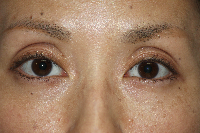


image path =  /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset/799.JPG
目が2個検出されました
[[ 128  475  759  759]
 [1457  469  849  849]]
[ex,ey] = 128,475 [ew,eh] = 759,759


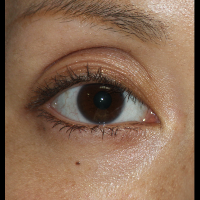

[ex,ey] = 1457,469 [ew,eh] = 849,849


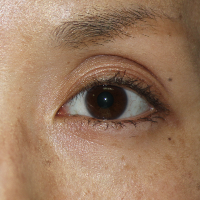

In [11]:
img_resized_list, side_list = crop_bilateral(in_path, 500)

# #検出された画像を確認
# src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
# plt.imshow(src)

#**ここからがメイン**

In [ ]:
orig_folder = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset" #olympiaのデータセット
path_list = glob.glob(orig_folder+"/*")
path = path_list[0]
path


'/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset/19.JPG'

In [10]:
orig_folder = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset" #olympiaのデータセット
dst_folder = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_250px_uni_periocular"


#処理時間の計測
start = time.time()

#もしdst_folderがあれば削除して新しく作り直す
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(dst_folder)

path_list = glob.glob(orig_folder+"/*")

num=0
for path in path_list:
    img_resized_list, side_list = crop_bilateral(path, 250, showImage=False
                                                 ) #両眼抜き出して250pxで保存（crop時にエラーが出るものは削除される）
    for img, side in zip(img_resized_list, side_list):
        if side == 0:
            sidestr = "R"
        elif side == 1:
            sidestr = "L"
        cv2.imwrite(dst_folder +"/"+ os.path.basename(path).split(".")[0]+"_"+sidestr+".JPG", img)
        num+=1

print("")
print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print (f"image_num:{num}")


ストリーミング出力は最後の 5000 行に切り捨てられました。
[[ 191  469  809  809]
 [1559  472  826  826]]
[ex,ey] = 191,469 [ew,eh] = 809,809
[ex,ey] = 1559,472 [ew,eh] = 826,826

image path =  /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset/288.JPG
目が2個検出されました
[[ 161  407  819  819]
 [1537  427  785  785]]
[ex,ey] = 161,407 [ew,eh] = 819,819
[ex,ey] = 1537,427 [ew,eh] = 785,785

image path =  /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset/964.JPG
目が2個検出されました
[[ 153  529  781  781]
 [1504  579  799  799]]
[ex,ey] = 153,529 [ew,eh] = 781,781
[ex,ey] = 1504,579 [ew,eh] = 799,799

image path =  /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset/289.JPG
目が2個検出されました
[[1539  547  855  855]
 [ 107  554  828  828]]
[ex,ey] = 1539,547 [ew,eh] = 855,855
[ex,ey] = 107,554 [ew,eh] = 828,828

image path =  /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset/290.JPG
目が2個検出されました
[[ 160  621  670  670]
 [1623  613  740  740]]
[ex,ey] = 160,621 [ew,eh] = 670,670
[ex,ey] = 1623,613 [e